In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import analysis_pca
import generate_linear_model


Ts = 1000
data_path = r'C:\Users\IBS\Desktop\python_code_N2'
save_path = r'C:\Users\IBS\Desktop\figures'

In [2]:
#For FN data

import pre_processing

ppss = pre_processing.pre_processing(Ts, data_path, save_path)
[final_cat, data_cat, val_cat, dur_cat, rejectedXY_cat] = ppss.datasorting_orientation(1)

apca = analysis_pca.analysis_pca(Ts, data_cat, save_path)
data_cat_sm = apca.smoothing_data()

In [6]:
import numpy as np

def generate_linear_model_c(data, pram):

    vpeak = np.abs(pram[:][0])  # peak velocity
    sdur = np.abs(pram[:][1])   # duration
    ss = data              # rate matrix

    ss0 = np.nanmean(ss, axis=0)  # mean rate across trials
    dss = ss - ss0                # deviation from mean rate
    v0 = np.nanmean(vpeak)        # mean peak velocity
    r0 = np.nanmean(15. / sdur)   # mean average velocity

    dv = vpeak - v0
    dr = 15 / sdur - r0
    dz = np.stack((dv, dr), axis=1)  # shape (Trial, 2)

    # Full model 
    w12 = np.linalg.lstsq(dz, dss, rcond=None)[0]

    wv = w12[0, :]  # velocity coefficients
    wr = w12[1, :]  # duration coefficients

    # Reduced model with only velocity
    wv0 = (dv.T @ dss) / (dv.T @ dv)  # shape (Time,)

    # Reduced model with only duration
    wr0 = (dr.T @ dss) / (dr.T @ dr)  # shape (Time,)

    linmod = {
        'wv0': wv0,
        'wr0': wr0,
        'wv': wv,
        'wr': wr,
    }

    return linmod

In [152]:
peak = np.abs(pram[:][0])  # peak velocity
sdur = np.abs(pram[:][1])   # duration

v0 = np.nanmean(vpeak)        # mean peak velocity
r0 = np.nanmean(15. / sdur)   # mean average velocity

dv = vpeak - v0
dr = 15 / sdur - r0

In [4]:
peak = []
for a in range(np.shape(val_cat)[0]):
    M = []
    for ori in range(8):
        temp = val_cat[a][ori]
        M.append(np.max(temp,axis = 1))
        # peak[a][ori]  = np.max(temp,axis = 1)
    peak.append(M)

peak = np.array(peak, dtype = object)

In [7]:
# Trial averaged results

peak_m = []
dur_cat_m = []
for a in range(np.shape(val_cat)[0]):
    M = []
    M2 = []
    for ori in range(8):
        temp = peak[a][ori]
        temp2 = dur_cat[a][ori]
        M.append(np.mean(temp, axis = 0))
        M2.append(np.mean(temp2, axis = 0))
    peak_m.append(M)
    dur_cat_m.append(M2)

peak_m = np.array(peak_m)
dur_cat_m = np.array(dur_cat_m)

final = []
for ori_num in range(8):
    temp_data = data_cat_sm[ori_num, :, :]
    pram = np.array([peak_m[:, ori_num], dur_cat_m[:, ori_num]])
        
    linmod = generate_linear_model_c(temp_data, pram)
    final.append(linmod)

In [8]:
# Raw data results

peak_t = []
dur_cat_t = []
data_raw = []
for ori_num in range(8):
    M = []
    M2 = []
    M3 = []
    for a in range(np.shape(val_cat)[0]):
        temp = peak[a, ori_num]
        temp2 = np.array(dur_cat)[a, ori_num]
        temp3 = np.array(data_cat)[a, ori_num]
        M.append(temp)
        M2.append(temp2)
        M3.append(temp3)
    peak_t.append(np.concatenate(M))
    dur_cat_t.append(np.concatenate(M2))
    data_raw.append(np.concatenate(M3))

peak_t = np.array(peak_t, dtype=object)
dur_cat_t = np.array(dur_cat_t, dtype=object)
data_raw = np.array(data_raw, dtype=object)

final_t = []
for ori_num in range(8):
    temp_data = data_raw[ori_num]
    pram = np.array([peak_t[ori_num], dur_cat_t[ori_num]])
    
    linmod = generate_linear_model_c(temp_data, pram)
    final_t.append(linmod)

In [10]:
plot_data = {}
for ori_num in range(8):
    
    temp = final[ori_num]

    pp1 = temp['wv0']
    pp2 = temp['wv']
    pp3 = temp['wr0']
    pp4 = temp['wr']

    plot_data[ori_num] = [pp1, pp2, pp3, pp4]

In [17]:
from scipy.ndimage import gaussian_filter1d
ssig = 5

plot_data2 = {}
for ori_num in range(8):
    
    temp = final_t[ori_num]

    pp1 = temp['wv0']
    pp2 = temp['wv']
    pp3 = temp['wr0']
    pp4 = temp['wr']

    zpp1 = gaussian_filter1d(np.array(pp1), sigma=ssig)
    zpp2 = gaussian_filter1d(np.array(pp2), sigma=ssig)
    zpp3 = gaussian_filter1d(np.array(pp3), sigma=ssig)
    zpp4 = gaussian_filter1d(np.array(pp4), sigma=ssig)

    plot_data2[ori_num] = [zpp1, zpp2, zpp3, zpp4]

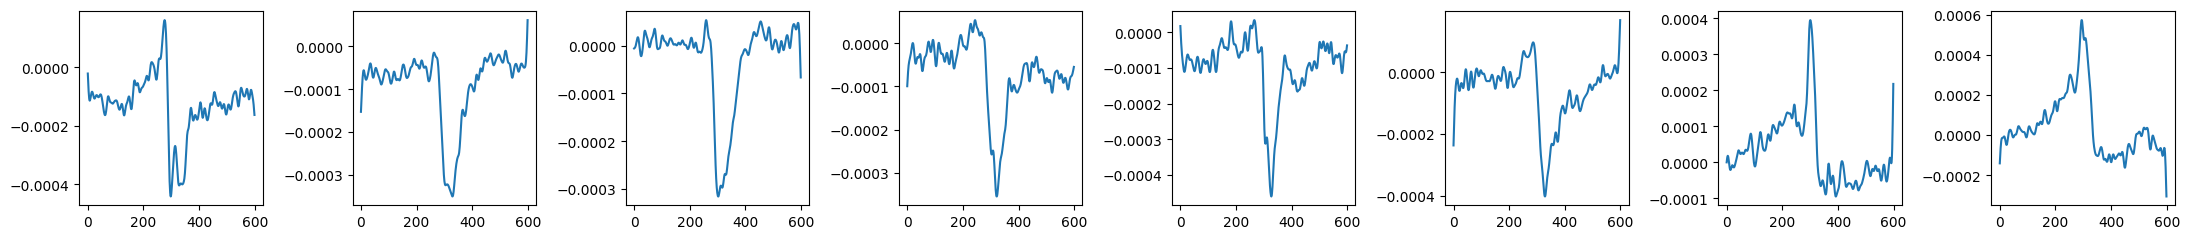

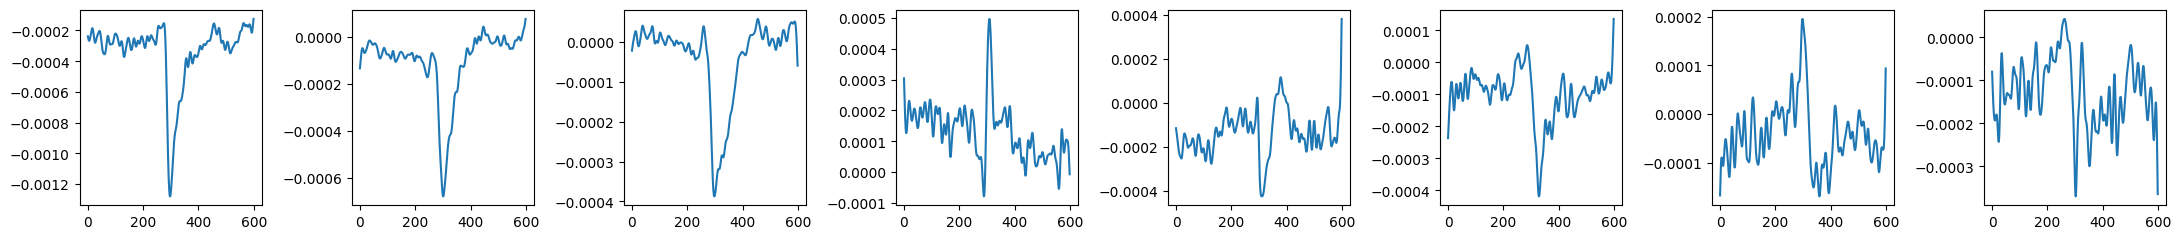

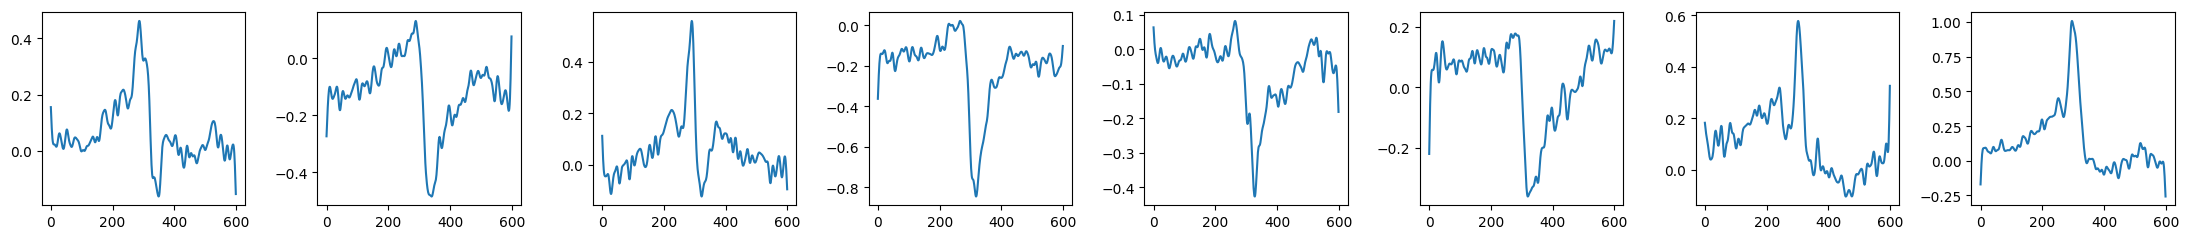

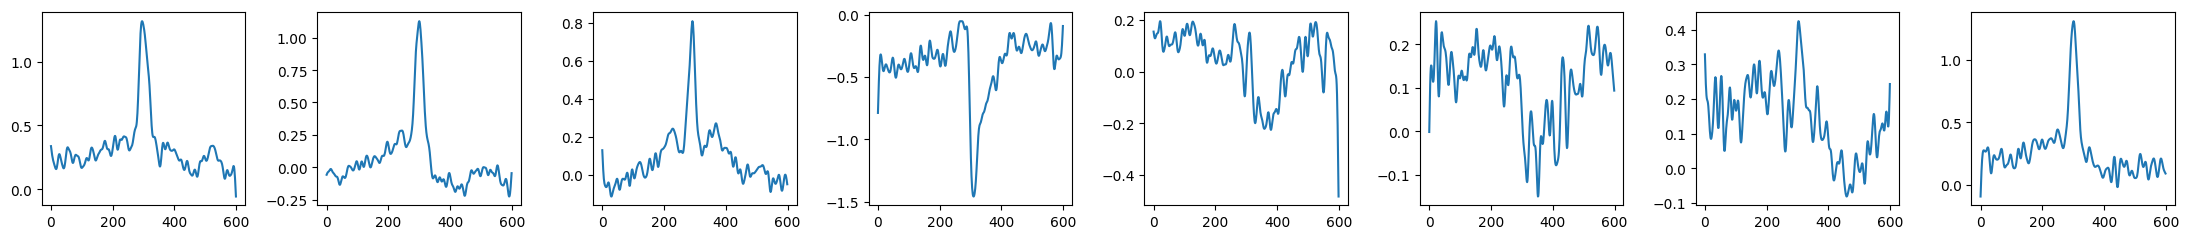

In [15]:
# Plotting 1
from matplotlib import gridspec

for b in range(4):
    fig = plt.figure(figsize=(22, 2.5))
    gs = gridspec.GridSpec(1, 8)
    for a in range(8):
        ax = fig.add_subplot(gs[0, a])
        ax.plot(plot_data[a][b])
    plt.tight_layout()
    plt.show()

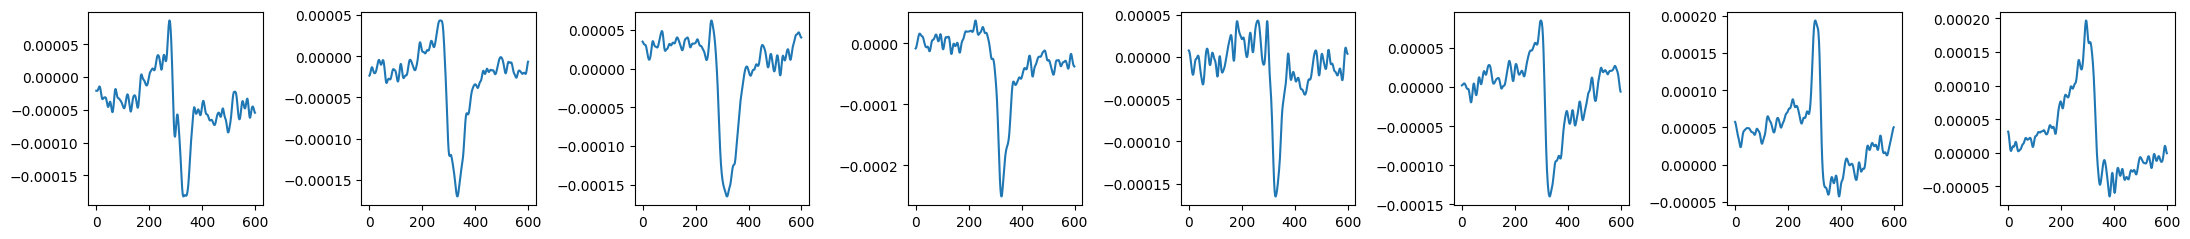

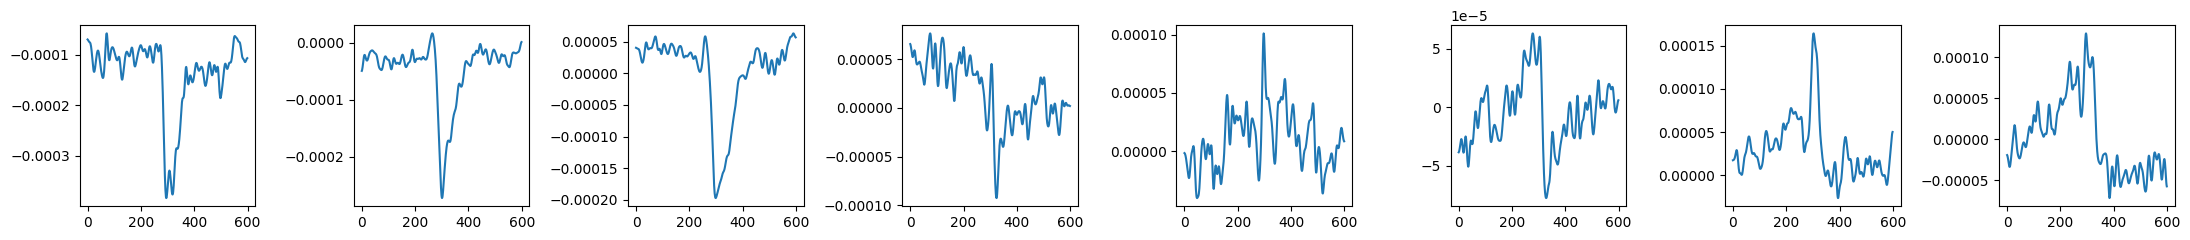

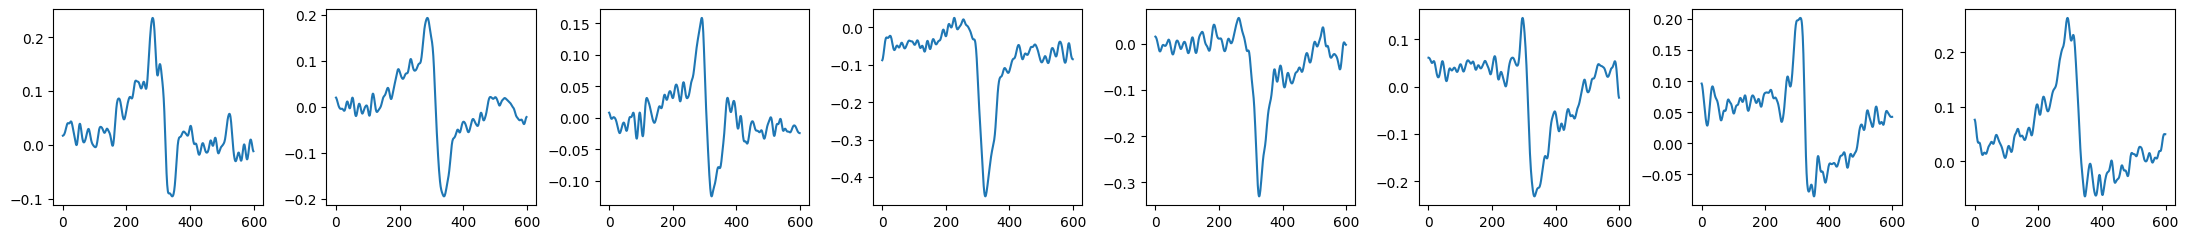

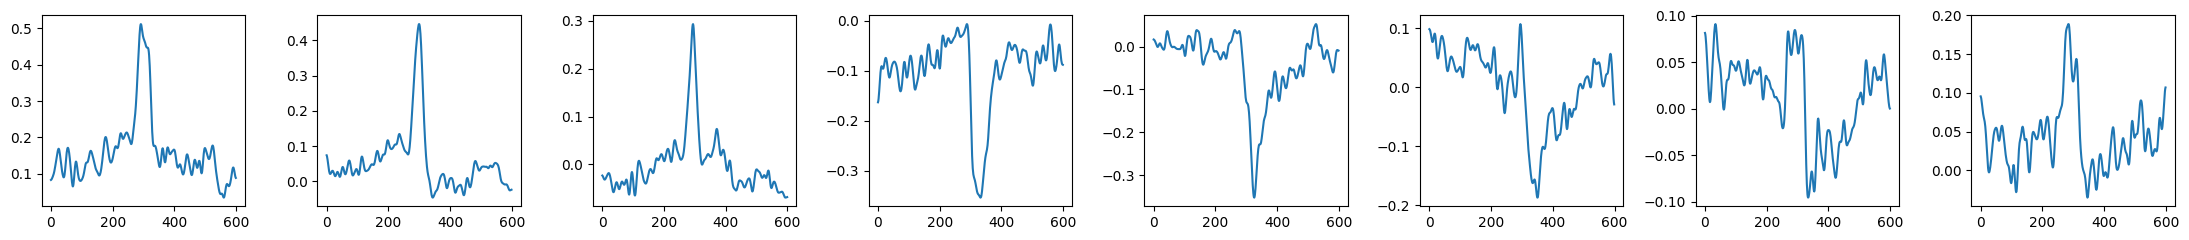

In [18]:
# Plotting 2
from matplotlib import gridspec

for b in range(4):
    fig = plt.figure(figsize=(22, 2.5))
    gs = gridspec.GridSpec(1, 8)
    for a in range(8):
        ax = fig.add_subplot(gs[0, a])
        ax.plot(plot_data2[a][b])
    plt.tight_layout()
    plt.show()